# Проект

- Проект
- Описание Проекта
- Детальный План
- Библиотеки + Выгрузка Данных
- Исследовательский Анализ
- Обьединение Данных
- Юридические Ограничения
- CNN Извлечение Вектора
- Векторизация Текста
- NN + Hyperparameters tunning
- Функция Поиска
- Вывод

# Описание Проекта

Сервис. На запрос ввиде описания фотографии сервис представлает фотографии похожие по смыслу. <br/>
<br/>
Извлекать смысл из описания будем с помощью векторизации. <br/>
Сверточная сеть будет извлекать смысл из фотографий. <br/>
Нужно найти сеть которая будет предсказывать если описание подходит фотографии. <br/>

# Детальный План

Предобработка данных до разбития на валидационный датасет<br/>
(оценка экспертов, юридические ограничения, лемматизация, векторизация изображений)<br/>
Предобработка данных после разбития на валидационный датасет (векторизация текста)<br/>
Линейная регрессия<br/>
Перебор разных нейронных моделей<br/>

# Библиотеки + Выгрузка Данных

In [1]:
import os
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
spacy.load('en_core_web_sm')
import en_core_web_sm

from tqdm import tqdm
tqdm.pandas()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from PIL import Image

In [2]:
np.random.seed(2023)
random.seed(2023)

In [3]:
os.listdir('./datasets')

['test_images',
 'test_images.csv',
 '.DS_Store',
 'train_dataset.csv',
 'ExpertAnnotations.tsv',
 'CrowdAnnotations.tsv',
 'train_images',
 'test_queries.csv']

In [4]:
test_images = pd.read_csv('./datasets/test_images.csv')
test_images = test_images.rename(columns={'image':'file_name'})
test_images.sample(3)

,file_name
56,782401952_5bc5d3413a.jpg
12,2885891981_6b02620ae9.jpg
68,957682378_46c3b07bcd.jpg


In [5]:
train_dataset = pd.read_csv('./datasets/train_dataset.csv')
train_dataset = train_dataset.rename(columns={'image':'file_name'})
train_dataset.sample(3)

,file_name,query_id,query_text
1345,2421446839_fe7d46c177.jpg,533483374_86c5d4c13e.jpg#2,a dog on the beach .
2741,2913965136_2d00136697.jpg,2813033949_e19fa08805.jpg#2,A white and black dog is jumping in the air tr...
3914,2902269566_419d9f1d8e.jpg,2340206885_58754a799a.jpg#2,Three dogs in the snow .


In [6]:
ExpertAnnotations = pd.read_csv('./datasets/ExpertAnnotations.tsv', sep='\t', 
                                names=['file_name', 'query_id', 'score_1', 'score_2', 'score_3'])
ExpertAnnotations.sample(3)

,file_name,query_id,score_1,score_2,score_3
4690,3593392955_a4125087f6.jpg,2723477522_d89f5ac62b.jpg#2,3,3,3
161,1287073593_f3d2a62455.jpg,2708686056_1b8f356264.jpg#2,1,1,1
4999,3720366614_dfa8fe1088.jpg,2963573792_dd51b5fbfb.jpg#2,1,1,1


In [7]:
CrowdAnnotations = pd.read_csv('./datasets/CrowdAnnotations.tsv', sep='\t', 
                                names=['file_name', 'query_id', 'score_1', 'score_2', 'score_3'])
CrowdAnnotations.sample(3)

,file_name,query_id,score_1,score_2,score_3
27453,3214573346_d3a57f0328.jpg,3128164023_ebe8da4c32.jpg#2,0.000000,0,3
18079,2796801478_8ebd7e550b.jpg,2868575889_2c030aa8ae.jpg#2,0.333333,1,2
14017,2549968784_39bfbe44f9.jpg,539751252_2bd88c456b.jpg#2,0.333333,1,2


In [8]:
test_queries = pd.read_csv('./datasets/test_queries.csv', sep='|', index_col=0)
test_queries = test_queries.rename(columns={'image':'file_name'})
test_queries.sample(3)

,query_id,query_text,file_name
134,2517284816_9b8fd3c6b6.jpg#4,Middle school aged kids are showing their scho...,2517284816_9b8fd3c6b6.jpg
56,2060031241_a3ae7a06bb.jpg#1,a baby is holding a controller to a video game...,2060031241_a3ae7a06bb.jpg
299,3351418768_596ef7fd6f.jpg#4,A woman in purple with two children in the mou...,3351418768_596ef7fd6f.jpg


# Предобработка Данных + Исследовательский Анализ

<div style="padding:1rem;background:aqua;">
    Проверим выбросы и ошибки
</div>

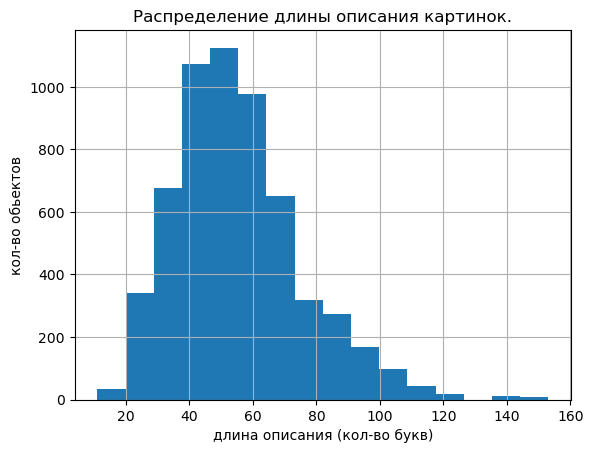

In [9]:
train_dataset.query_text.str.len().hist(bins=16)
plt.title('Распределение длины описания картинок.')
plt.xlabel('длина описания (кол-во букв)')
plt.ylabel('кол-во обьектов')
plt.show()

Несмотря на то что данных мала в диапазоне 120-140, они не выглядят как выбросы.

In [10]:
ExpertAnnotations.describe()

,score_1,score_2,score_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Видно, что все данные находятся в правильном диапазоне.

In [11]:
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   score_1    47830 non-null  float64
 3   score_2    47830 non-null  int64  
 4   score_3    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Проверил если правельный формат данных

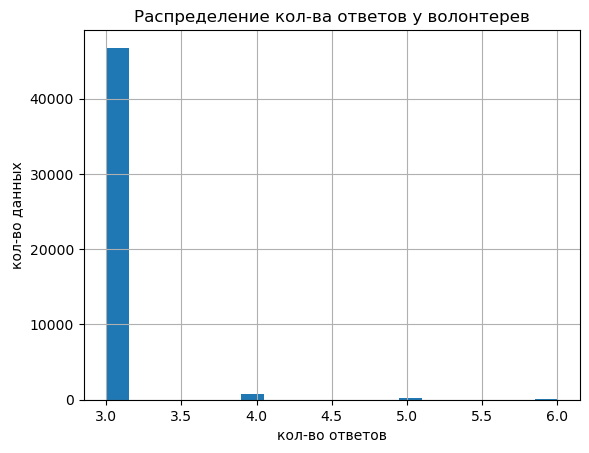

In [12]:
(CrowdAnnotations.score_2 + CrowdAnnotations.score_3).hist(bins=20)
plt.title('Распределение кол-ва ответов у волонтерев')
plt.xlabel('кол-вo ответов')
plt.ylabel('кол-вo данных')
plt.show()

Тут видно что минимальное кол-во ответов 3, а выбросы не особо важны.

# Обьединение Данных

Описание ExpertAnnotations: <br/>
1. Имя файла
2. Идентификатор описнания <br/>
3-5 Оценки по шкале 1-4

Описание CrowdAnnotations: <br/>
1. Имя файла
2. Идентификатор описания
3. Доля людей, подтвердивших, что описание соответсвует изображению
4. Количество человек, подтвердивших, что описание соответствует изображению
5. Количество человек, подтвердивших, что описание не соответствует изображению

<div style="padding:1rem;background:aqua;">
    - Так как оценка соотвествия у нашей модели будем шкала 0-1, нам нужны похожие данные. <br/>
    - Оценки экспертов можно обьеденить в одну среднюю оценку, потом поменять по формуле (x-1)/3. <br/>
    - Оценку волонтерев можно считать как долю. А важность будет 30% по отношению к экспертам.
</div>

In [13]:
prompt_score = ExpertAnnotations.copy()

In [14]:
prompt_score['score'] = prompt_score.score_1 + prompt_score.score_2 + prompt_score.score_3

In [15]:
# divide by 3 (3 summed scores), divide by 3 (ratio 0-1)
prompt_score.score = prompt_score.score.apply(lambda x: ((x/3) - 1)/3)

In [16]:
prompt_score = prompt_score.drop(columns=['score_1', 'score_2', 'score_3'])

In [17]:
prompt_score.sample(3)

,file_name,query_id,score
3592,3256043809_47258e0b3e.jpg,3585487286_ef9a8d4c56.jpg#2,0.333333
1964,2654514044_a70a6e2c21.jpg,2238019823_79318d1f11.jpg#2,0.000000
1039,224369028_b1ac40d1fa.jpg,2101457132_69c950bc45.jpg#2,0.000000


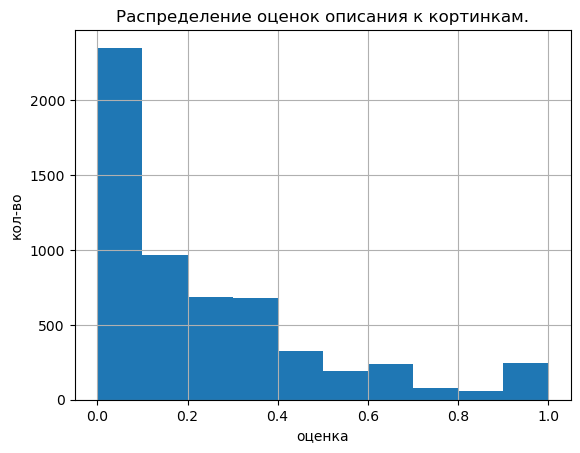

In [18]:
prompt_score.score.hist()
plt.title('Распределение оценок описания к кортинкам.')
plt.xlabel('оценка')
plt.ylabel('кол-во')
plt.show()

In [19]:
step = pd.merge(prompt_score, CrowdAnnotations, how='left', on=['query_id', 'file_name'])

In [20]:
step.head()

,file_name,query_id,score,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN,NaN,NaN


Где есть волонтерские данные соеденим их с важностью 30%, а где нет, оставим прежнюю оценку.

In [21]:
def join_scores(row):
    if not math.isnan(row.score_1):
        return row.score * 0.7 + row.score_1 * 0.3
    return row.score

step.score = step.apply(lambda row: join_scores(row), axis=1)

In [22]:
step.head()

,file_name,query_id,score,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.077778,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN,NaN,NaN


In [23]:
prompt_score = step.drop(columns=['score_1', 'score_2', 'score_3'])

In [24]:
df = pd.merge(prompt_score, train_dataset, on=['query_id', 'file_name'], how='inner')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   score       5822 non-null   float64
 3   query_text  5822 non-null   object 
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


In [26]:
df.head()

,file_name,query_id,score,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.077778,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .


In [27]:
df_test = pd.merge(prompt_score, test_queries, on=['query_id', 'file_name'], how='inner')

In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   0 non-null      object 
 1   query_id    0 non-null      object 
 2   score       0 non-null      float64
 3   query_text  0 non-null      object 
dtypes: float64(1), object(3)
memory usage: 124.0+ bytes


<div style="padding:1rem;background:aqua;">
    - Видно что нет оценки экспертов для тестированых запросов, надо будет делить тренировачные данные. <br/>
</div>

# Юридические Ограничения

<div style="padding:1rem;background:aqua;">
    - Векторизируем текст простым способом. Лемматизируем слова, извлечем BagOfWords и TF-IDF. <br/>
    - До того как мы векторизируем текст, будет легко найти данные с юридическими ограничениями. <br/>
</div>

In [29]:
nlp = en_core_web_sm.load()

In [30]:
doc = nlp("I am hanging out in a green garden")
print([(token.lemma_, token.pos_) for token in doc])

[('I', 'PRON'), ('be', 'AUX'), ('hang', 'VERB'), ('out', 'ADP'), ('in', 'ADP'), ('a', 'DET'), ('green', 'ADJ'), ('garden', 'NOUN')]


Для того чтобы извлечь смысл нам только нужен 'VERB' & 'NOUN' & 'ADJ'.

In [31]:
def extract_lemma(text):
    doc = nlp(text)
    out = []
    for token in doc:
        if token.pos_ == 'VERB' or token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
            out.append(token.lemma_)
    return out

In [32]:
df['text_lemma'] = df.query_text.progress_apply(lambda x: extract_lemma(x))

100%|██████████████████████████████████████| 5822/5822 [00:22<00:00, 255.76it/s]


In [33]:
df.head(15)

,file_name,query_id,score,query_text,text_lemma
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,A young child is wearing blue goggles and sitt...,"[young, child, wear, blue, goggle, sit, float,..."
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.077778,A girl wearing a yellow shirt and sunglasses s...,"[girl, wear, yellow, shirt, sunglass, smile]"
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .,"[man, sleep, blanket, city, street]"
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...,"[woman, play, long, red, ribbon, empty, square]"
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .,"[chinese, market, street, winter, time]"
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...,"[soccer, ball, head, man, wear, black, short, ..."
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,0.000000,A young boy dressed in a red uniform kicks the...,"[young, boy, dress, red, uniform, kick, soccer..."
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.077778,A man and woman look back at the camera while ...,"[man, woman, look, camera, stand, front, red, ..."
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,0.000000,A white dog jumps to catch a blue ball in a li...,"[white, dog, jump, catch, blue, ball, living, ..."
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,0.333333,A little boy shakes the snow off of a tree .,"[little, boy, shake, snow, tree]"


In [34]:
test_queries['text_lemma'] = test_queries.query_text.progress_apply(lambda x: extract_lemma(x))

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 243.15it/s]


In [35]:
test_queries.head()

,query_id,query_text,file_name,text_lemma
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"[blonde, boy, camouflage, shirt, other, blue, ..."
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,"[boy, squirt, water, gun, other]"
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,"[boy, spray, other, water]"
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,"[child, wear, jean, squirt, water, other]"
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,"[young, boy, squirt, water, other]"


<div style="padding:1rem;background:aqua;">
    - У нас теперь есть лист со словами, мы можем найти если в нем есть слова которые могут описивать людей младше 16 лет. <br/>
</div>

In [36]:
underage_list = [
    'young',
    'youth',
    'minor',
    'adolescent',
    'teenager',
    'youngster',
    'child',
    'kid',
    'juvenile',
    'preteen',
    'teen',
    'junior',
    'youngling',
    'sprout',
    'offspring',
    'pupil',
    'infant',
    'toddler',
    'baby',
    'minion',
    'pubescent',
    'tween',
    'boy',
    'girl',
    'student'
]

In [37]:
underage_set = set(underage_list)

In [38]:
def contains_underage_word(x):
    my_set = set(x)
    return len(my_set & underage_set) != 0

In [39]:
df['underage_word'] = df.text_lemma.progress_apply(lambda x: contains_underage_word(x))

100%|███████████████████████████████████| 5822/5822 [00:00<00:00, 959951.17it/s]


In [40]:
df.sample(5)

,file_name,query_id,score,query_text,text_lemma,underage_word
1795,2588927489_f4da2f11ec.jpg,2856080862_95d793fa9d.jpg#2,0.000000,Men playing soccer in a field,"[man, play, soccer, field]",False
1746,2559503010_84f20b3bc9.jpg,2815256108_fc1302117d.jpg#2,0.000000,Two men are talking on the street ; one is poi...,"[man, talk, street, point, sign, say, red, box...",False
3280,3187492926_8aa85f80c6.jpg,2599444370_9e40103027.jpg#2,0.155556,Two black dogs are dog paddling in a sparkling...,"[black, dog, dog, paddle, sparkling, blue, pool]",False
4711,359837950_9e22ffe6c2.jpg,2602085456_d1beebcb29.jpg#2,0.000000,A topless woman is covered in mud .,"[topless, woman, cover, mud]",False
4927,3694991841_141804da1f.jpg,1174525839_7c1e6cfa86.jpg#2,0.155556,"A young , long-haired , girl on the beach , is...","[young, long, haired, girl, beach, jump, air]",True


In [41]:
test_queries['underage_word'] = test_queries.text_lemma.progress_apply(lambda x: contains_underage_word(x))

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 604715.11it/s]


In [42]:
test_queries.sample(5)

,query_id,query_text,file_name,text_lemma,underage_word
462,661749711_6f408dad62.jpg#2,A Yorkie trying to catch a red toy .,661749711_6f408dad62.jpg,"[try, catch, red, toy]",False
17,1319634306_816f21677f.jpg#2,A large tan dog sits on a grassy hill .,1319634306_816f21677f.jpg,"[large, tan, dog, sit, hill]",False
448,572618443_647483ca82.jpg#3,Two boys playing in water .,572618443_647483ca82.jpg,"[boy, play, water]",True
107,2431120202_b24fe2333a.jpg#2,A little girl wearing a purple winter coat and...,2431120202_b24fe2333a.jpg,"[little, girl, wear, purple, winter, coat, sun...",True
211,3044359043_627488ddf0.jpg#1,A dog is jumping into a pool for a swim compet...,3044359043_627488ddf0.jpg,"[dog, jump, pool, swim, competition]",False


<div style="padding:1rem;background:aqua;">
    - Можно выбросить данные с несовершеннолетними. <br/>
</div>

In [43]:
print('Пропорция данных которые мы выбросим: {:.2f}'.format(1 - (df.underage_word.count() - df.underage_word.sum())/df.underage_word.count()))

Пропорция данных которые мы выбросим: 0.28


In [44]:
df = df[df.underage_word == False].drop(columns=['underage_word']).reset_index(drop=True)

In [45]:
df.head()

,file_name,query_id,score,query_text,text_lemma
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,A man sleeps under a blanket on a city street .,"[man, sleep, blanket, city, street]"
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,A woman plays with long red ribbons in an empt...,"[woman, play, long, red, ribbon, empty, square]"
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,Chinese market street in the winter time .,"[chinese, market, street, winter, time]"
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,A soccer ball is above the head of a man weari...,"[soccer, ball, head, man, wear, black, short, ..."
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.077778,A man and woman look back at the camera while ...,"[man, woman, look, camera, stand, front, red, ..."


# CNN Извлечение Вектора

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171 entries, 0 to 4170
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   4171 non-null   object 
 1   query_id    4171 non-null   object 
 2   score       4171 non-null   float64
 3   query_text  4171 non-null   object 
 4   text_lemma  4171 non-null   object 
dtypes: float64(1), object(4)
memory usage: 163.1+ KB


In [47]:
data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_dataframe(
    df, directory='./datasets/train_images', x_col='file_name', y_col='score', class_mode='raw',
    target_size=(224,224))

Found 4171 validated image filenames.


In [48]:
backbone = ResNet50(include_top=False, weights='imagenet')
model = Sequential()
model.add(backbone)

Metal device set to: Apple M1 Pro


In [49]:
X_vision = model.predict(data_flow)

2023-06-11 18:36:15.151512: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


131/131 [==============================] - 19s 137ms/step


In [50]:
X_vision = np.array([x.flatten() for x in X_vision])

In [51]:
X_vision.shape

(4171, 100352)

In [52]:
df['vision'] = pd.Series(list(X_vision))

# Векторизация Текста

In [53]:
df['text_lemma_joined'] = df.text_lemma.apply(lambda x: " ".join(x))

<div style="padding:1rem;background:aqua;">
    - На этом этапе можно разделить "df" на валидационную и тестировочные выборки. <br/>
</div>

In [54]:
gss_test = GroupShuffleSplit(n_splits=1, train_size=.6)

In [55]:
train_indices, valid_test_indices = next(gss_test.split(X=df, y=df, groups=df['file_name']))

In [56]:
df_train, df_valid_test = df.loc[train_indices], df.loc[valid_test_indices]

In [57]:
gss_valid = GroupShuffleSplit(n_splits=1, train_size=.5)

In [58]:
valid_indices, test_indices = next(gss_valid.split(X=df_valid_test, y=df_valid_test, groups=df_valid_test['file_name']))

In [59]:
df_valid_test = df_valid_test.reset_index(drop=True)

In [60]:
df_test, df_valid =  df_valid_test.loc[test_indices], df_valid_test.loc[valid_indices]

In [61]:
df_train.shape

(2505, 7)

In [62]:
df_valid.shape

(829, 7)

In [63]:
df_test.shape

(837, 7)

In [64]:
count_vect = CountVectorizer()

In [65]:
X_train_count = count_vect.fit_transform(df_train.text_lemma_joined)

In [66]:
X_train_count

<2505x837 sparse matrix of type '<class 'numpy.int64'>'
	with 13352 stored elements in Compressed Sparse Row format>

In [67]:
tf_idf = TfidfVectorizer()

In [68]:
X_train_tfidf = tf_idf.fit_transform(df_train.text_lemma_joined)

In [69]:
X_train_tfidf

<2505x837 sparse matrix of type '<class 'numpy.float64'>'
	with 13352 stored elements in Compressed Sparse Row format>

In [70]:
X_train = sp.hstack([X_train_count, X_train_tfidf])

In [71]:
X_train

<2505x1674 sparse matrix of type '<class 'numpy.float64'>'
	with 26704 stored elements in Compressed Sparse Row format>

In [72]:
X_valid = sp.hstack([count_vect.transform(df_valid.text_lemma_joined),
                     tf_idf.transform(df_valid.text_lemma_joined)])

In [73]:
X_test = sp.hstack([count_vect.transform(df_test.text_lemma_joined),
                    tf_idf.transform(df_test.text_lemma_joined)])

#  NN + Hyperparameters tunning

<div style="padding:1rem;background:aqua;">
    - Проверим как будет работать линейная регрессия. (скорее всего будет работать очень плохо, связь нужно искать между параметрами)<br/>
    - Проверим RanfomForestRegressor.<br/>
    - Проверим как будут работать нейронные сети.<br/>
</div>

In [74]:
X_train = X_train.toarray()
X_train_vision = df_train.vision.to_numpy()
X_train_vision = np.vstack(X_train_vision)
X_train = np.concatenate((X_train, X_train_vision), axis=1)

In [75]:
X_valid = X_valid.toarray()
X_valid_vision = df_valid.vision.to_numpy()
X_valid_vision = np.vstack(X_valid_vision)
X_valid = np.concatenate((X_valid, X_valid_vision), axis=1)

In [76]:
X_test = X_test.toarray()
X_test_vision = df_test.vision.to_numpy()
X_test_vision = np.vstack(X_test_vision)
X_test = np.concatenate((X_test, X_test_vision), axis=1)

In [77]:
X_train.shape

(2505, 102026)

In [78]:
X_valid.shape

(829, 102026)

In [79]:
model_lr = LinearRegression()

In [80]:
y_train = df_train.score

In [81]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [82]:
z_valid = model_lr.predict(X_valid)

In [83]:
y_valid = df_valid.score

In [84]:
mean_absolute_error(y_valid, z_valid)

63529585.67707889

In [85]:
forest_params = [{'max_depth': [5, 10], 'n_estimators': [1, 2]}]

In [86]:
model_rf = RandomForestRegressor()

In [87]:
grid_search = GridSearchCV(estimator=model_rf, param_grid=forest_params, scoring='neg_mean_absolute_error')

In [88]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [5, 10], 'n_estimators': [1, 2]}],
             scoring='neg_mean_absolute_error')

In [89]:
print(grid_search.best_params_)

{'max_depth': 5, 'n_estimators': 2}


In [90]:
print(grid_search.best_score_ * -1)

0.2018476380728918


In [103]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3)

model_ff = tf.keras.Sequential()
model_ff.add(tf.keras.layers.Dense(1000, input_shape=(102026,), activation='relu'))
model_ff.add(tf.keras.layers.Dense(100, activation='relu'))
model_ff.add(tf.keras.layers.Dense(10, activation='relu'))
model_ff.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.legacy.Adam()

model_ff.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [104]:
model_ff.fit(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=20, callbacks=[callback], verbose=2)

Epoch 1/20
79/79 - 8s - loss: 0.2100 - mae: 0.2100 - val_loss: 0.2144 - val_mae: 0.2144 - 8s/epoch - 97ms/step
Epoch 2/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 77ms/step
Epoch 3/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 72ms/step
Epoch 4/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 71ms/step
Epoch 5/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 70ms/step
Epoch 6/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 70ms/step
Epoch 7/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 71ms/step
Epoch 8/20
79/79 - 6s - loss: 0.2064 - mae: 0.2064 - val_loss: 0.2144 - val_mae: 0.2144 - 6s/epoch - 70ms/step


In [105]:
print('RandomForestRegressor: ', mean_absolute_error(y_valid, grid_search.best_estimator_.predict(X_valid)))

RandomForestRegressor:  0.20699247145234684


In [106]:
print('Feed-forward neural network: ', mean_absolute_error(y_valid, model_ff.predict(X_valid)))

26/26 [==============================] - 1s 31ms/step
Feed-forward neural network:  0.2143948532368315


In [114]:
model_best = grid_search.best_estimator_

<div style="padding:1rem;background:aqua;">
    - RanfomForestRegressor показал лучший результат.<br/>
</div>

# Функция Поиска

<div style="padding:1rem;background:aqua;">
    - Выберем 8 queries.<br/>
    - Прогоним test_images, test_queries, по нашей схеме.<br/>
    - Выведем результат поиска.<br/>
</div>

In [115]:
def process_text_age_restiction(text):
    text_lemma = extract_lemma(text)
    return contains_underage_word(text_lemma)

In [116]:
def process_images(df):
    df = df.copy()
    df['score_fake'] = 0
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow = data_gen.flow_from_dataframe(
        df, directory='./datasets/test_images', x_col='file_name', y_col='score_fake', class_mode='raw',
        target_size=(224,224))
    backbone = ResNet50(include_top=False, weights='imagenet')
    model = Sequential()
    model.add(backbone)
    X_vision = model.predict(data_flow)
    X_vision = np.array([x.flatten() for x in X_vision])
    df['vision'] = pd.Series(list(X_vision))
    return df

In [117]:
def process_text(text):
    text_lemma = extract_lemma(text)
    text_lemma_joined = " ".join(text_lemma)
    return sp.hstack([count_vect.transform([text_lemma_joined]), 
                      tf_idf.transform([text_lemma_joined])]).toarray()[0]

In [118]:
def score_query(vision, text):
    soup = [np.concatenate((text, vision))]
    out = model_best.predict(soup)[0]
    return out

In [119]:
def deep_image_search(query):
    is_restricted_query = process_text_age_restiction(query)
    if is_restricted_query:
        print('This image is unavailable in your country in compliance with local laws.')
    else:
        df_search = test_images.copy()
        df_search = process_images(df_search)
        text = process_text(query)
        df_search['score'] = df_search.vision.apply(lambda x: score_query(x, text))
        best_idx = df.score.idxmax()
        best_image = df.file_name.loc[best_idx]
        im = Image.open('./datasets/train_images/' + best_image)
        im = im.resize((224, 224))
        im_array = np.array(im)
        plt.imshow(im_array)
        plt.title(query)
        plt.axis('off')
        plt.show()

Found 100 validated image filenames.
4/4 [==============================] - 1s 212ms/step


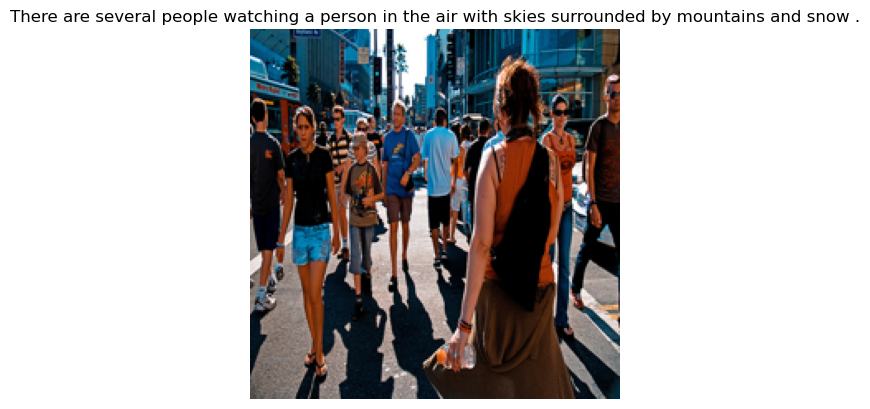

This image is unavailable in your country in compliance with local laws.
Found 100 validated image filenames.
4/4 [==============================] - 2s 269ms/step


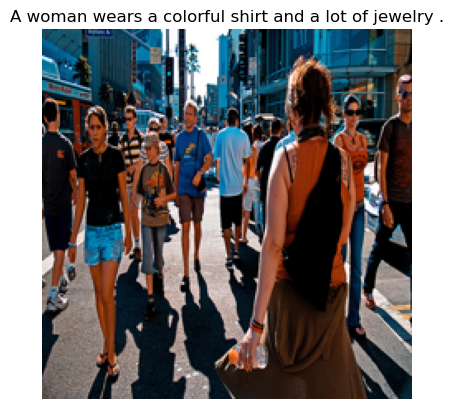

This image is unavailable in your country in compliance with local laws.
Found 100 validated image filenames.
4/4 [==============================] - 2s 266ms/step


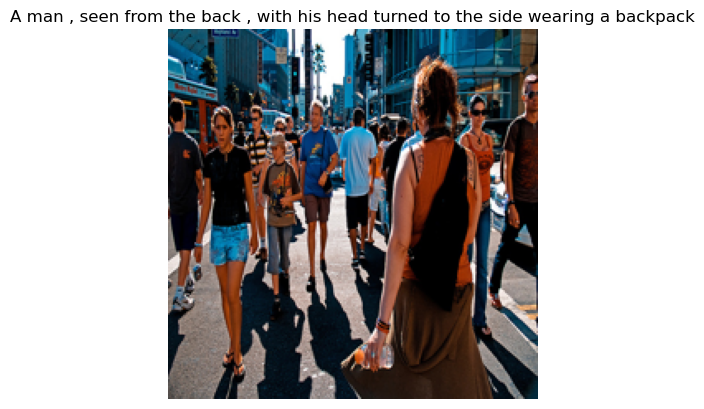

This image is unavailable in your country in compliance with local laws.
Found 100 validated image filenames.
4/4 [==============================] - 1s 183ms/step


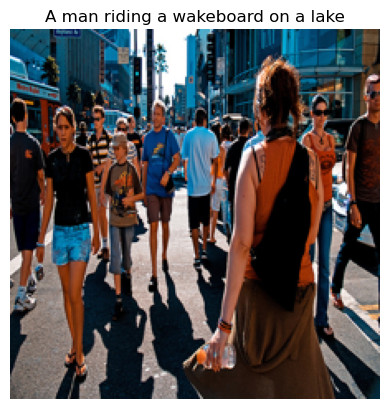

Found 100 validated image filenames.
4/4 [==============================] - 2s 270ms/step


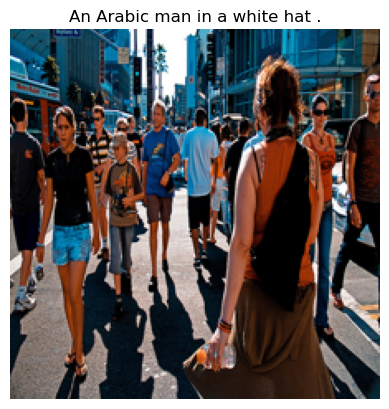

In [120]:
for query in test_queries.query_text.sample(8):
    deep_image_search(query)

# Вывод

<div style="padding:1rem;background:aqua;">
    - Поиск выводит одни и те же картинки.<br/>
    - PoC не прошла. Есть вероятность что модель как то не так натренировалась, но мне кажется я все сделал правильно.<br/>
</div>